# Roller Coaster of Data:
## Analyzing roller coaster length on coasters around the world

# Goals:
## - Acquire data on roller coasters to find drivers of coaster length


## - Use those drivers to build a model to predict coaster length


## - Use that model to attempt to predict lengths of roller coasters

In [20]:
import warnings
from importlib import reload

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import explore as e
import evaluate as ev
import wrangle as w
import model as m
from scipy import stats

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
warnings.simplefilter('ignore')

# Executive Summary

## Acquire
- Data was downloaded from [Kaggle](https://www.kaggle.com/datasets/thedevastator/roller-coaster-data-from-around-the-world)
- Before cleaning, data set had 2802 rows and 10 columns
- Each row represents a roller coaster
- Each column represents an observation about the roller coaster

## Prepare
- Removed any coasters that are rumored, under construction, or closed, temporarily or permanently
    - These accounted for the majority of the null values.
- Make corrections to outdated and incorrect data
- Engineer values
    - Update `material_type` to `steel_track` by changing values based on manufacturer of Hybrid coasters.
        - Arrow and RMC roller coasters have wooden supports and steel track
        - GCI and Gravity Group roller coasters have steel support with wooden track
    - Collapsed any manufacturers with 7 or fewer coasters to 'Other'
    - Based on training data `length`, grouped manufacturers into `man_groups`
- After cleaning, data has 1187 rows and 11 columns



### Exploration
- Use visualizations to see patterns in the data and try to determine drivers/indicators of coaster length
-  Use statistical testing, as necessary, to confirm or reject the relationship between features
- Use clustering to explore adding related features together to attempt to further update data 
   

## Model and Evaluation
- Used `TweedieRegressor`,`LassoLars`, and `LinearRegression` models in sklearn. 
- Evaluated model performance against training and validation data 
- Best performing model was evaluated on test data set

# Acquire and Prepare

In [3]:
train, validate, test = w.wrangle_coasters()

### A look at the data

In [4]:
train.head()

,name,steel_track,seating_type,speed,height,length,num_inversions,manufacturer,park,status,man_group
374,The Raven,False,Sit Down,77.0,33.0,832.0,0.0,CCI,Holiday World,status.operating,1
111,Oblivion,True,Sit Down,110.0,20.0,372.0,0.0,B&M,Alton Towers,status.operating,0
1700,Juvelen,True,Sit Down,85.0,12.0,1000.0,0.0,Intamin,Djurs Sommerland,status.operating,1
655,Dæmonen,True,Floorless,77.0,28.0,564.0,3.0,B&M,Tivoli Gardens,status.operating,0
1830,Tabalugas Achterbahn,True,Sit Down,40.0,9.0,222.0,0.0,Zierer,Holiday Park,status.operating,4


# Explore

## Question 1:
### Do steel roller coasters vary significantly in length from wooden ones?

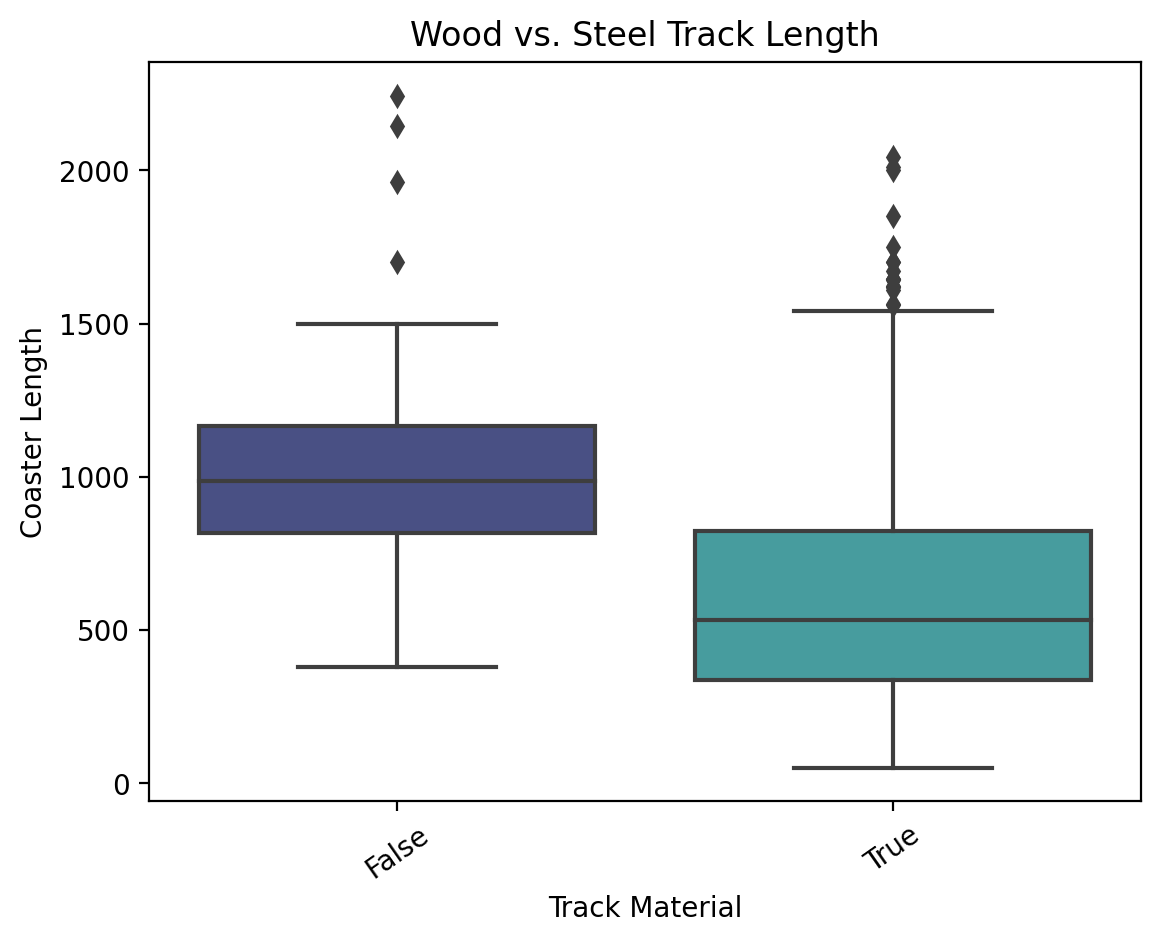

In [5]:
e.wood_vs_steel(train)

### Is there a positive relationship between material type and length?
#### $H_0$: $\mu_{steel} \geq \mu_{wood} \geq \mu_{hybrid}$
#### $H_a$: $\mu_{steel} < \mu_{wood} < \mu_{hybrid}$

### Assumptions:
1. sets are independent ✅
2. sets are normally distributed ✅
3. Equal Variance❓

In [6]:
e.wood_steel_levene(train)

## t = 3.7104805449349656 

 ## p = 0.0545003130170775 

## Because t > 0 and $\alpha$ < p, we failed to   reject $H_0$

### Because variances are not equal, we will use the `equal_variance`

In [7]:
e.wood_steel_ttest(train)

## t = 8.23414260312759 

 ## p = 1.054675738327497e-12 

## Because t > 0 and $\alpha$ > p, we   reject $H_0$

## From this, we can conclude that coaster track type is a likely a significant indicator of coaster length

## Question 2: Is there a relationship between coaster manufacturer and length?

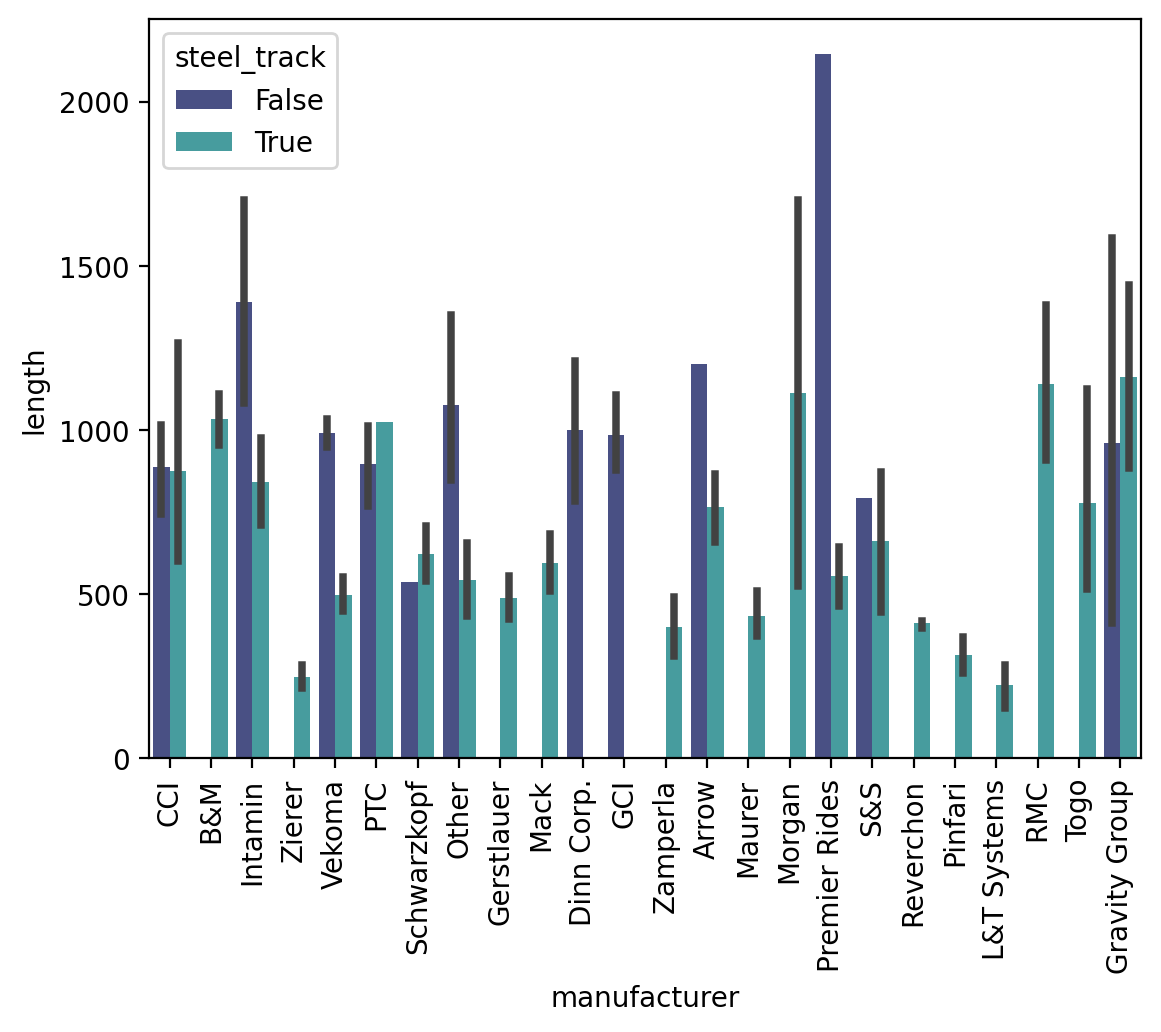

In [8]:
reload(e)
e.manufacturers_v_length(train)

## Many manufactuerers has a significant variety of coaster shapes and sizes. To simplify this, I created the man_group feature ranking the manufcaturers by their max length in the `train` dataset.

## Question: Is there a linear relationship between speed and length?

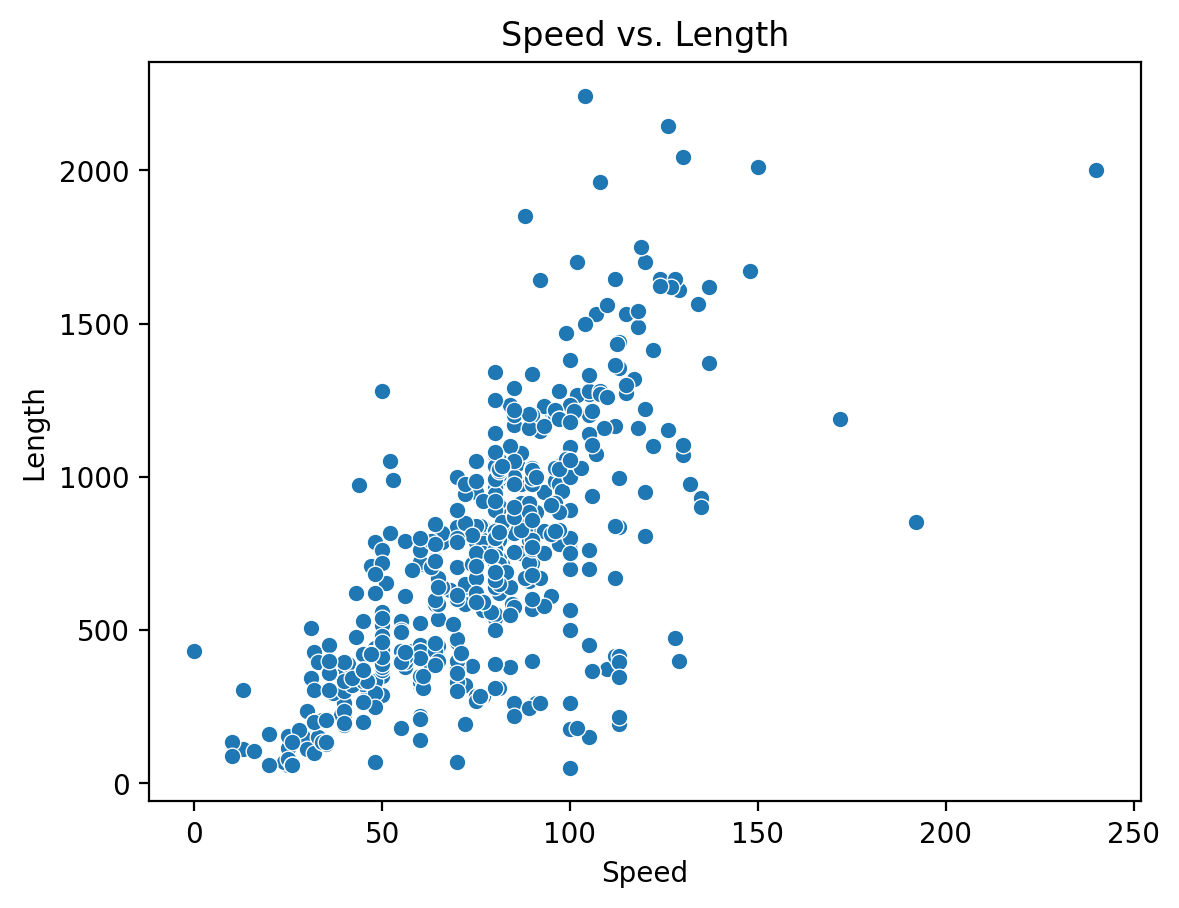

In [9]:
reload(e)
e.speed_length(train)

### Hypotheses:
$H_{0}$: There is no strong linear correlation between speed and length

$H_{a}$: There is a linear correlation between speed and length

### Assumptions:
- Features are not ordinal ✅
- Features are normally distributed

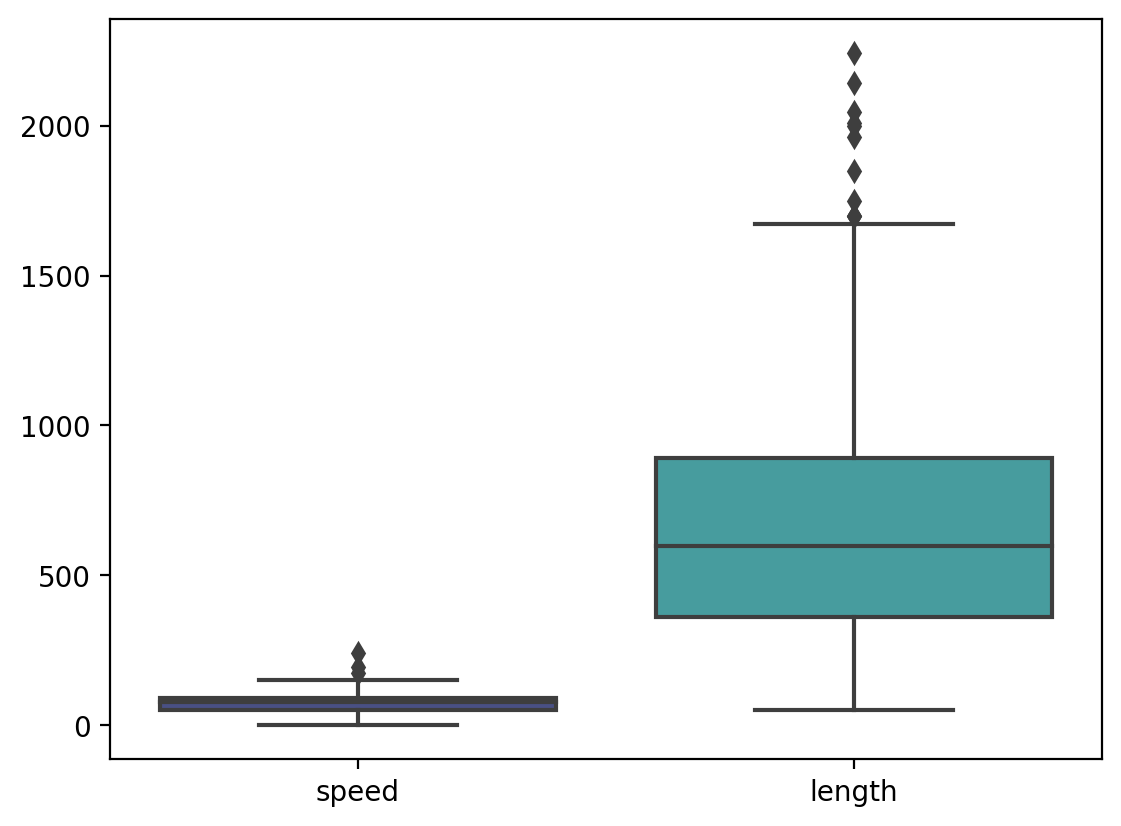

In [10]:
reload(e)
e.speed_len_boxplot(train)

#### Because the values are not normally distributed, we will use the spearmanr test.

In [11]:
reload(e)
e.speed_len_spearmanr(train)

## p = 9.192757381035074e-105
## r = 0.7148187774306639

## Because $\alpha$ > p,we  reject $H_0$

With a correlation coefficient of 0.69, we can assume a positive correlation between speed and length, and as such is a good potential candidate for a driver of coaster length

## Question 4: Could clustering on `speed` and `man_group` improve model performance?

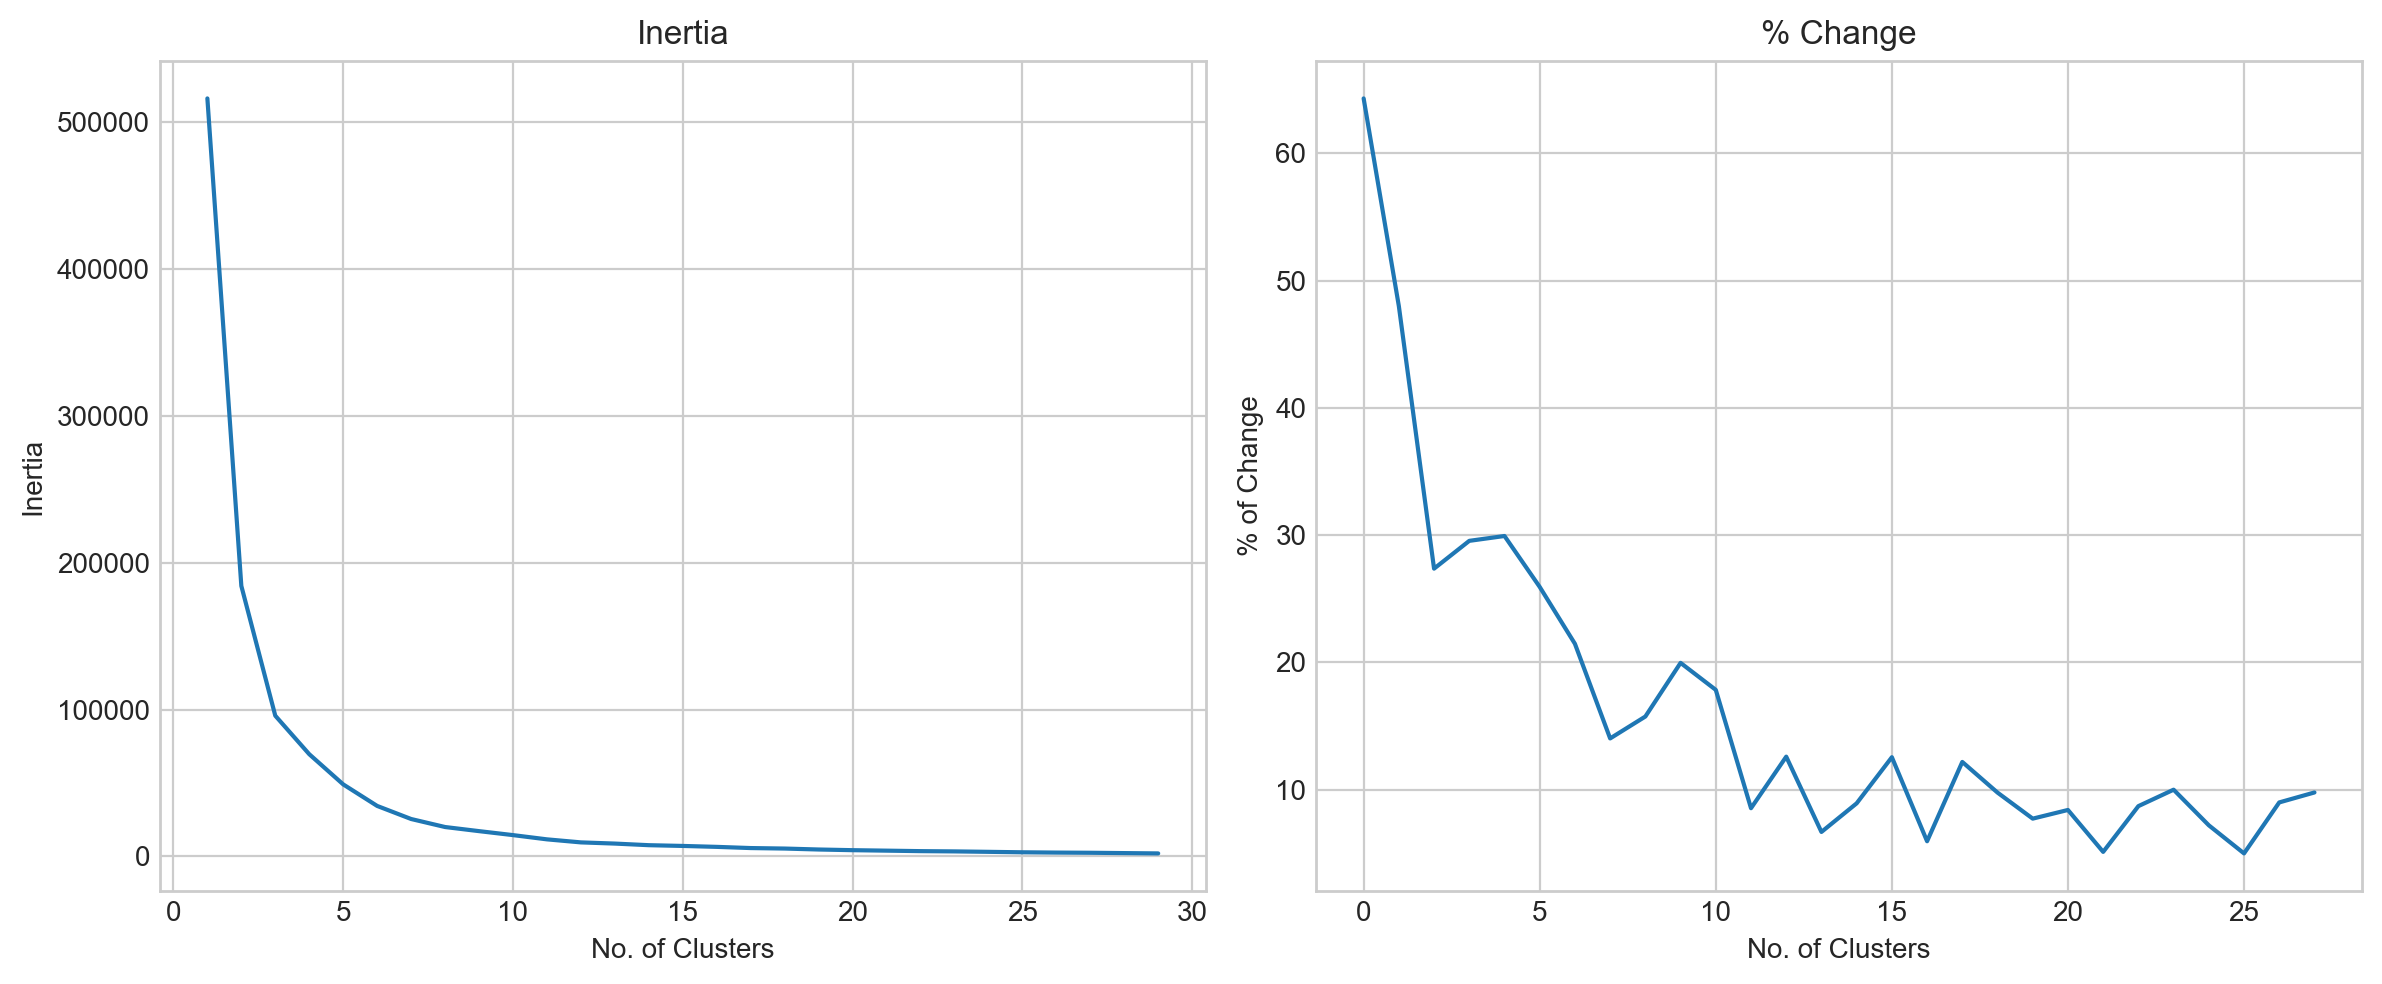

In [12]:
e.generate_elbow(train[['speed','num_inversions']])

#### Based on the elbow graph and the percent change, we will cluster with k=4

<AxesSubplot: xlabel='length', ylabel='Density'>

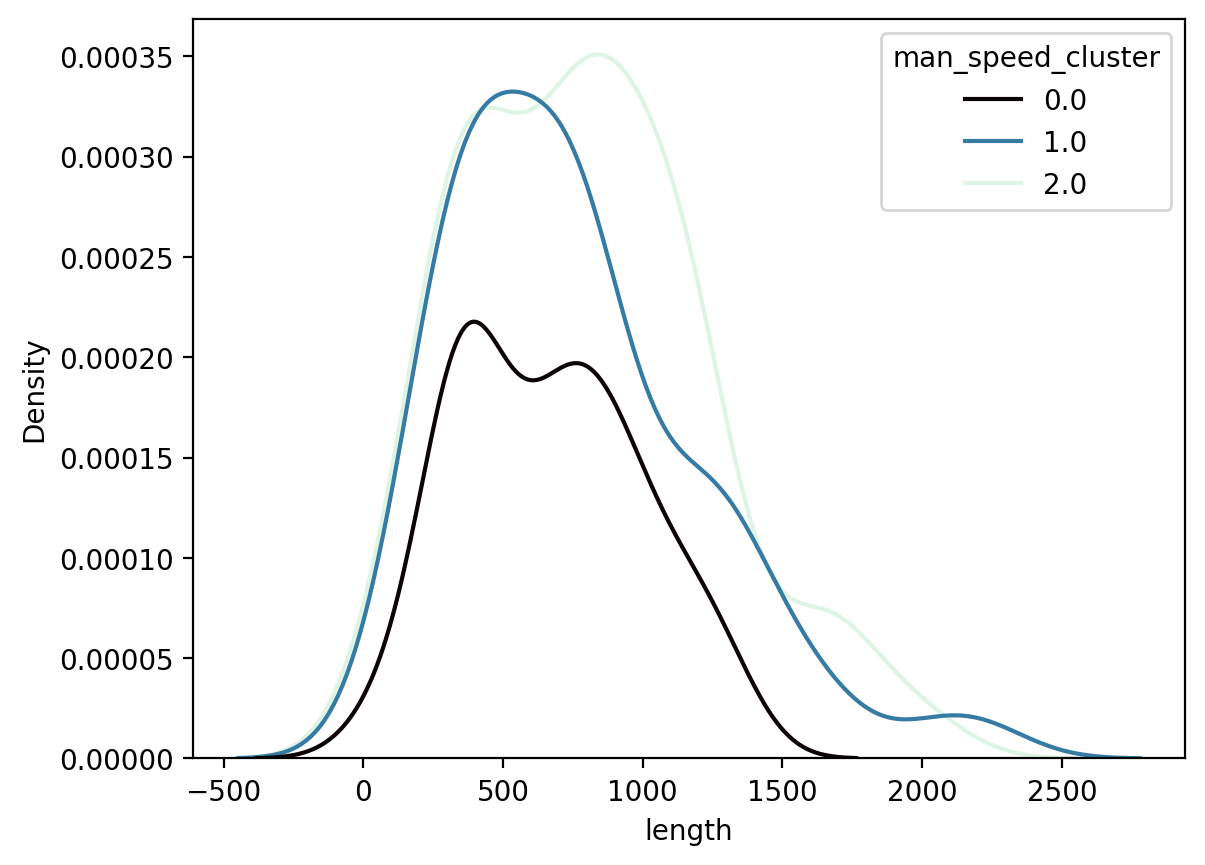

In [13]:
reload(m)
from sklearn.cluster import KMeans
train['man_speed_cluster'] = m.cluster(train[['speed','num_inversions']],KMeans(3))
sns.kdeplot(data=train,x='length',hue='man_speed_cluster',palette='mako')

#### Because clustering does not appear to distribute the means in any substantial way, I have decided against clustering moving forward.

# Modeling

## Baseline

In [22]:
md,baseline = m.select_baseline(train.length)
md

|                 |         SSE |    MSE |    RMSE |
|:----------------|------------:|-------:|--------:|
| Mean Baseline   | 1.04585e+08 | 157745 | 397.172 |
| Median Baseline | 1.07079e+08 | 161506 | 401.878 |
### Because mean outperformed median on all metrics,         we will use mean as our baseline

## Took 2 approaches to modeling:
### 1. Used a single model on all roller coasters
### 2. Broke data set into wooden and steel roller coasters, running a separate model on each

### Approach 1: Use a single model across all roller coasters

In [25]:
reload(m)
m.try_models_train_validate(train, validate)

,Train,Validate
Linear Regression,264.933973,320.202225
Squared Regression,249.172382,295.400013
Cubed Regression,231.309010,300.265153
LASSO+LARS,264.933973,320.202225
LASSO+LARS^2,249.172382,295.400013
LASSO+LARS^3,231.309010,300.265153
GLM,264.933973,320.202225
GLM^2,249.172382,295.400013
GLM^3,231.309010,300.265153
Baseline,397.171592,421.870275


### Approach 2: Break data set into wooden and steel roller coasters and use a separate model on each

In [46]:
reload(m)
m.wood_steel_permutations(train,validate)

,Train,Validate
lr_lr_2,249.172382,295.400013
lr_ll_2,249.172382,295.400013
lr_tw_2,249.172382,295.400013
ll_lr_2,249.172382,295.400013
ll_ll_2,249.172382,295.400013


In [45]:
reload(m)
m.run_test(train,test)

,Test
LinearRegression,257.476066
Baseline,386.720765
